In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
import os
import numpy as np
import pandas as pd

from typing import Tuple, Dict, List
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision.transforms import functional
from torch.nn import DataParallel
from torch.optim import Adam
from torchinfo import summary

from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torchvision import transforms as T, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib
from matplotlib.cm import ScalarMappable

from train_utils.ADE_dataset import ADE_Dataset, train_val_split
from train_utils.trainer_ddp_segm import main
from train_utils.utils import plot_segm, predict_image_mask_miou
from models.Unet import Unet

import torch.multiprocessing as mp

In [3]:
BATCH_SIZE = 8
LR = 5*1e-2
NUM_CLASSES = 151
NUM_EPOCHS = 50

In [4]:
def download_data():
    if not os.path.exists('data'):
        os.mkdir('data')

    if not os.listdir('data'):
        !wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
        !unzip ADEChallengeData2016.zip -d data

download_data()

In [5]:
df = pd.read_csv('data/ADEChallengeData2016/color_coding_semantic_segmentation_classes - Sheet1.csv')
label2name = dict(zip(df['Idx'], df['Name']))
label2name[0] = 'background'
label2color = dict(zip(df['Idx'], df['Color_Code(hex)']))
label2color[0] = '#000000'

In [6]:
train_dataset, val_dataset = train_val_split(ADE_Dataset(root_dir=, train=True), val_size=0.05)
test_dataset = ADE_Dataset(root_dir='data/ADEChallengeData2016', train=False)

In [7]:
print(f'Train size = {len(train_dataset)}, Validation size = {len(val_dataset)}, Test size = {len(test_dataset)}')

Train size = 19199, Validation size = 1011, Test size = 2000


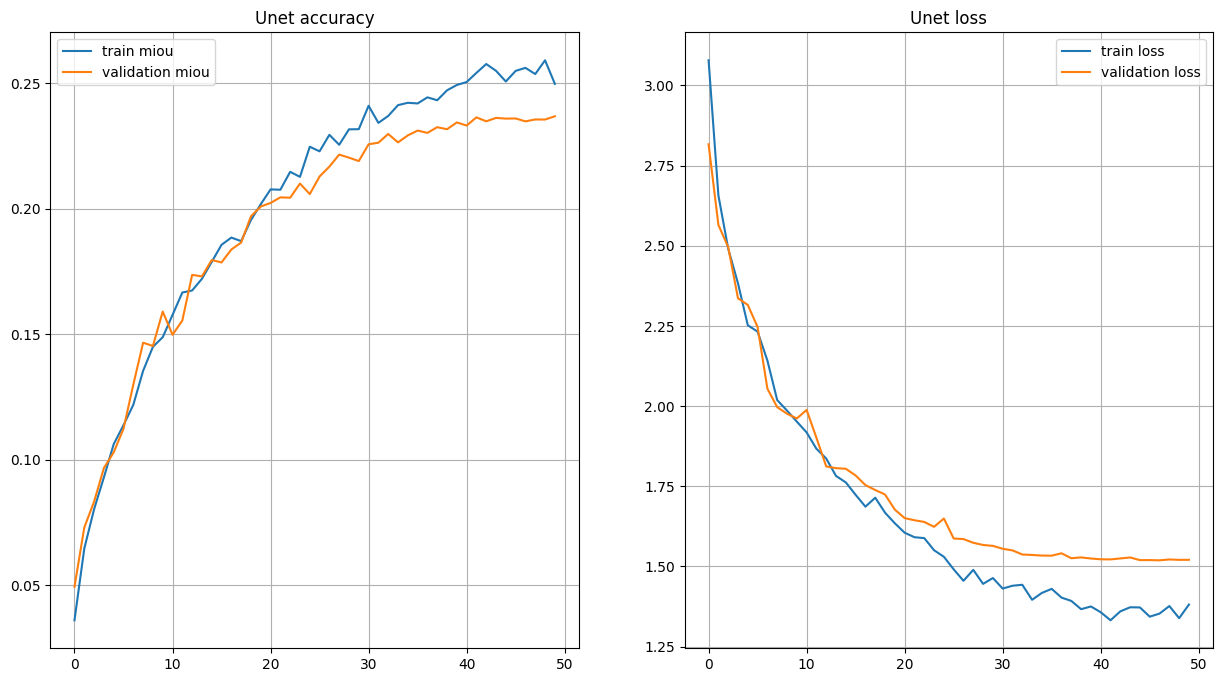

Validation accuracy: 0.237, best_val_acc: 0.237


Testing: 100%|██████████| 250/250 [00:42<00:00,  5.88it/s, val_miou=0.192]


In [8]:
world_size = torch.cuda.device_count()
parent_conn, child_conn = mp.Pipe(duplex=False)

model = Unet(num_classes=NUM_CLASSES)
optimizer = Adam(model.parameters(), lr=LR)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

mp.start_processes(
        main, 
        args=(
            world_size, 
            model, 
            NUM_EPOCHS,
            BATCH_SIZE,
            train_dataset,
            val_dataset,
            test_dataset,
            optimizer,
            scheduler,
            child_conn,
            'Unet',
            'snapshot.pt',
            True), 
       nprocs=world_size, 
       start_method='fork'
    )
results = parent_conn.recv()
child_conn.close()
parent_conn.close()

In [8]:
model = Unet(num_classes=151)

model.load_state_dict(torch.load('snapshot.pt'))

<All keys matched successfully>

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
test_image, test_mask = test_dataset.load_image(101)

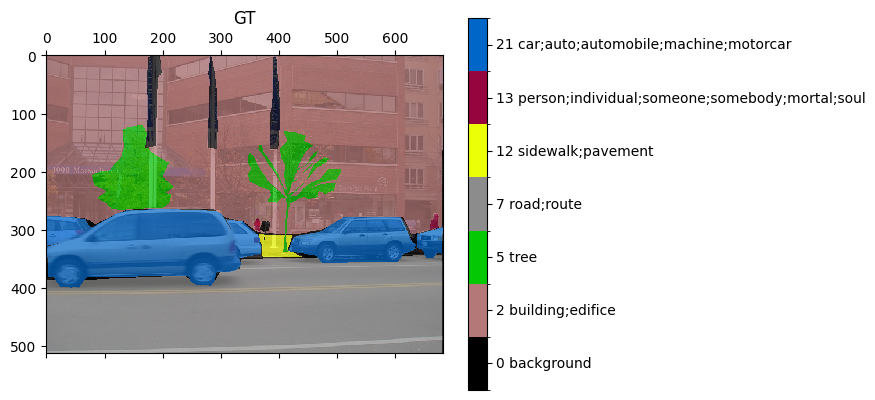

In [13]:
plot_segm(
    image=test_image, 
    mask=test_mask,
    alpha=0.7,
    label2name=label2name,
    label2color=label2color,
    title='GT'
)

In [14]:
predict = predict_image_mask_miou(model, test_image, test_mask, device)

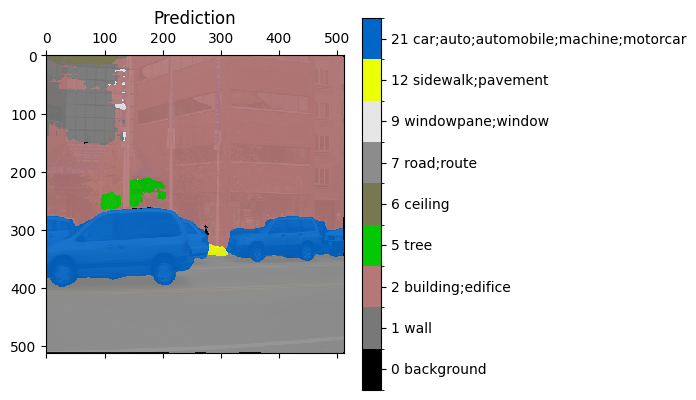

In [15]:
plot_segm(
    image=test_image, 
    mask=predict,
    alpha=0.9,
    label2name=label2name,
    label2color=label2color,
    title='Prediction'
)